<a href="https://colab.research.google.com/github/EShepotinnik/meth_viz/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Шепотинник Егор
### Группа М03-12Б


---

# Задание №3

In [1]:
!git clone 'https://github.com/EShepotinnik/meth_viz.git'

fatal: destination path 'meth_viz' already exists and is not an empty directory.


In [1]:
! pip install python-sat[pblib,aiger]

In [12]:
import pprint
import re
from pysat.solvers import Solver
from matplotlib import patches
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection

Задаем парсер текса


In [8]:
def parser(data):
    points = []
    all_boxes = []
    index_box = 1
    for row in data:
        point_xy, w_h, variants = row.splitlines()[0].split('\t')
        point_x, point_y = point_xy.split(',')
        point_x = int(point_x)
        point_y = int(point_y)
        w, h = w_h.split(',')
        w = int(w)
        h = int(h)

        point = (point_x, point_y)
        point_x_boxs = {point: []}
        
        for var_x, var_y in (var.split(',') for var in variants.split(" ")):
            var_x = int(var_x)
            var_y = int(var_y)
            box_x = point_x - var_x
            box_y = point_y - var_y
        
            box = (box_x, box_y, w, h,index_box, point)

            index_box +=1

            point_x_boxs[point].append(box)
            all_boxes.append(box)

        points.append(point_x_boxs)

    return points, all_boxes

Пересечения

In [3]:
def inters_x(box1, box2):
    return ((box1[0] <= box2[0] <= box1[0] + box1[2]) or (box2[0] <= box1[0] <= box2[0] + box2[2])) 

def inters_y(box1, box2):
    return ((box1[1] <= box2[1] <= box1[1] + box1[3]) or (box2[1] <= box1[1] <= box2[1] + box2[3]))

def inters(box1, box2):
    return inters_x(box1, box2) and inters_y(box1, box2)

Находим все пересечения

In [4]:
def find_all_intersect(all_box):
    all_inters = {}
    for box1 in all_box:
        for box2 in all_box:
            if (box1[5] == box2[5]) or (box1[4] == box2[4]) :
                continue
            elif inters(box1, box2):
                if box1[4] not in all_inters:
                    all_inters[box1[4]] = set()
                all_inters[box1[4]].add(box2[4])

                if box2[4] not in all_inters:
                    all_inters[box2[4]] = set()
                all_inters[box2[4]].add(box1[4])
    return all_inters

In [6]:
def sat_solv(all_boxes, points):
  
  all_inter = find_all_intersect(all_boxes)
  ind_boxes = {box[4]: box for box in all_boxes}

  with Solver(name="mc") as solver:
    for point in points:
      boxs_ids = [box[4] for box in next(iter(point.values()))]
      solver.add_atmost(boxs_ids, 1)
      solver.add_clause(boxs_ids)
    for box in all_boxes:
      if box[4] in all_inter:
        for confId in all_inter[box[4]]:
          solver.add_clause([-box[4], -confId])
    if solver.solve() == True:
      ids = solver.get_model()
      return [ind_boxes[idx] for idx in ids if idx > 0]
    else:
      print("Решение нет!")
      return 

In [13]:
def draw_labels(boxs, points):
    fig, ax = plt.subplots(figsize=(12, 8))

    patch_boxs = [patches.Rectangle((box[0], box[1]), box[2], box[3]) for i, box in enumerate(boxs)]
    patch_collection = PatchCollection(patch_boxs, facecolor='r', edgecolor='black')
    ax.add_collection(patch_collection)
    
    scatter_x = [p[0] for p in points]
    scatter_y = [p[1] for p in points]
    ax.scatter(scatter_x, scatter_y, color='black')

    plt.show()

In [14]:
file = open('meth_viz/bins/bin1.txt', "r")
all_points, all_boxes = parser(file)

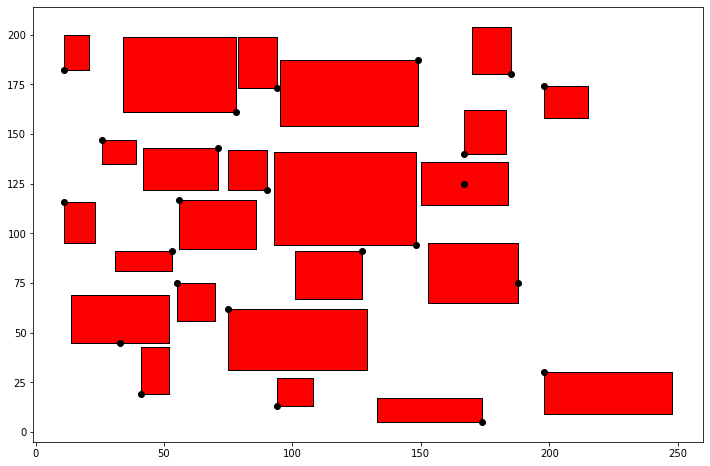

In [15]:
result_boxs = sat_solv(all_boxes, all_points)
draw_labels(result_boxs, [next(iter(point.keys())) for point in all_points])